### import libraries

In [25]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt

In [21]:
# Build your `wrangle` function
def wrangle(df):

    # Subset data: Apartments in "Distrito Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # divide into borough
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # drop 50% null value columns
    df.drop(columns = ["expenses", "floor"], inplace=True)

    # #drop low and high cardinality categorical data or features
    df.drop(columns = ["operation","property_type","properati_url","currency"],inplace=True)

    # #drop leaky columns
    df.drop(columns = [ "price","price_aprox_local_currency","price_per_m2","price_usd_per_m2"],inplace=True)

    #drop multicollinear columns
    df.drop(columns = ["surface_total_in_m2", 'rooms'], inplace=True)
    

    return df

In [22]:
df = pd.read_csv('mexico.csv', encoding = 'Latin-1')

In [23]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23140 entries, 0 to 23139
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   23140 non-null  object 
 1   property_type               23140 non-null  object 
 2   place_with_parent_names     23140 non-null  object 
 3   lat-lon                     20698 non-null  object 
 4   price                       22745 non-null  float64
 5   currency                    22745 non-null  object 
 6   price_aprox_local_currency  22745 non-null  float64
 7   price_aprox_usd             22745 non-null  float64
 8   surface_total_in_m2         8633 non-null   float64
 9   surface_covered_in_m2       22215 non-null  float64
 10  price_usd_per_m2            6012 non-null   float64
 11  price_per_m2                21320 non-null  float64
 12  floor                       1531 non-null   float64
 13  rooms                       621

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


In [33]:
df = wrangle(df)

In [34]:
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


Text(0.5, 1.0, 'Distribution of Apartment Prices')

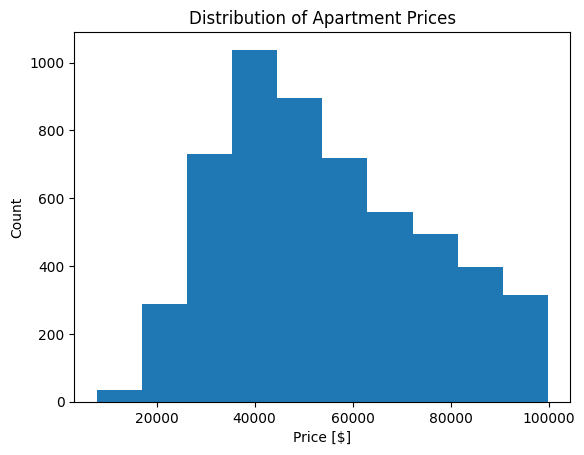

In [35]:
# Build histogram
import matplotlib.pyplot as plt
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel('Price [$]')
plt.ylabel('Count')

# Add title

plt.title("Distribution of Apartment Prices")



Text(0.5, 1.0, 'Mexico City: Price vs. Area')

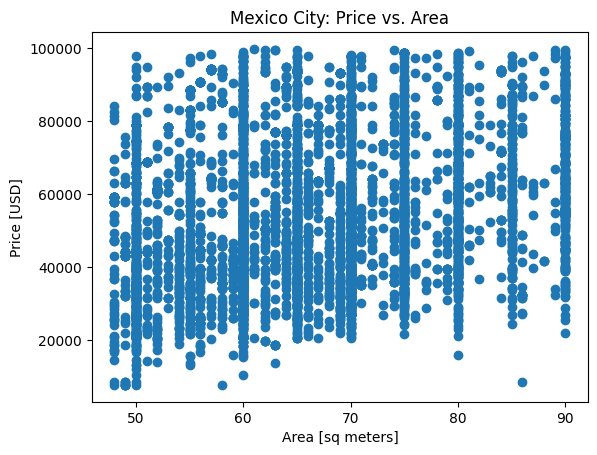

In [36]:
# Build scatter plot
plt.scatter(x= df['surface_covered_in_m2'] , y = df['price_aprox_usd'])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
# Add title
plt.title("Mexico City: Price vs. Area")




#### Split data into feature matrix `X_train` and target vector `y_train`.

In [37]:
# Split data into feature matrix `X_train` and target vector `y_train`.

X_train = df.drop(columns= ['price_aprox_usd'])
y_train = df['price_aprox_usd']

In [38]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54202.198002558485
Baseline MAE: 17206.49869506523


### builiding model

In [39]:
# Build Model
model = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
    Ridge()
)
    
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

###  test data

In [42]:
X_test = pd.read_csv('mexico-city-test-features.csv', encoding = 'Latin-1')
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


In [43]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53606.013439
1    53323.532445
2    34336.343842
3    53556.125543
4    68707.558562
dtype: float64

In [45]:
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, index=features)
feat_imp


surface_covered_in_m2               284.991851
lat                                 490.410611
lon                               -2476.064277
borough_Benito Juárez             13816.975053
borough_Iztacalco                   379.533847
borough_Azcapotzalco               2503.681881
borough_Coyoacán                   3834.048801
borough_Álvaro Obregón             3043.701288
borough_Iztapalapa               -13368.102264
borough_Cuauhtémoc                 -319.440108
borough_Tláhuac                  -14208.659861
borough_Miguel Hidalgo             2004.646937
borough_Venustiano Carranza       -5609.969392
borough_Tlalpan                   10346.978177
borough_Gustavo A. Madero         -6631.577745
borough_Xochimilco                  948.122862
borough_La Magdalena Contreras    -5907.894678
borough_Cuajimalpa de Morelos      9167.955201
dtype: float64

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

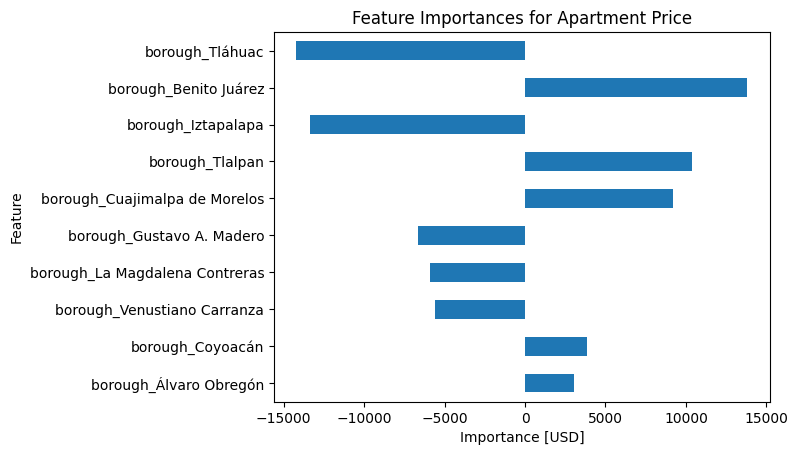

In [46]:
feat_imp.sort_values(key = abs).tail(10).plot(kind = "barh")

# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price")

